Processing: n_atoms=256, alpha=0.01
Processing: n_atoms=256, alpha=0.001
Processing: n_atoms=256, alpha=0.0001
Processing: n_atoms=256, alpha=1e-05
Processing: n_atoms=512, alpha=0.01
Processing: n_atoms=512, alpha=0.001
Processing: n_atoms=512, alpha=0.0001
Processing: n_atoms=512, alpha=1e-05
Processing: n_atoms=1024, alpha=0.01
Processing: n_atoms=1024, alpha=0.001
Processing: n_atoms=1024, alpha=0.0001
Processing: n_atoms=1024, alpha=1e-05
Processing: n_atoms=2048, alpha=0.01
Processing: n_atoms=2048, alpha=0.001
Processing: n_atoms=2048, alpha=0.0001
Processing: n_atoms=2048, alpha=1e-05


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.504e-07, tolerance: 3.856e-07
  model = cd_fast.enet_coordinate_descent(


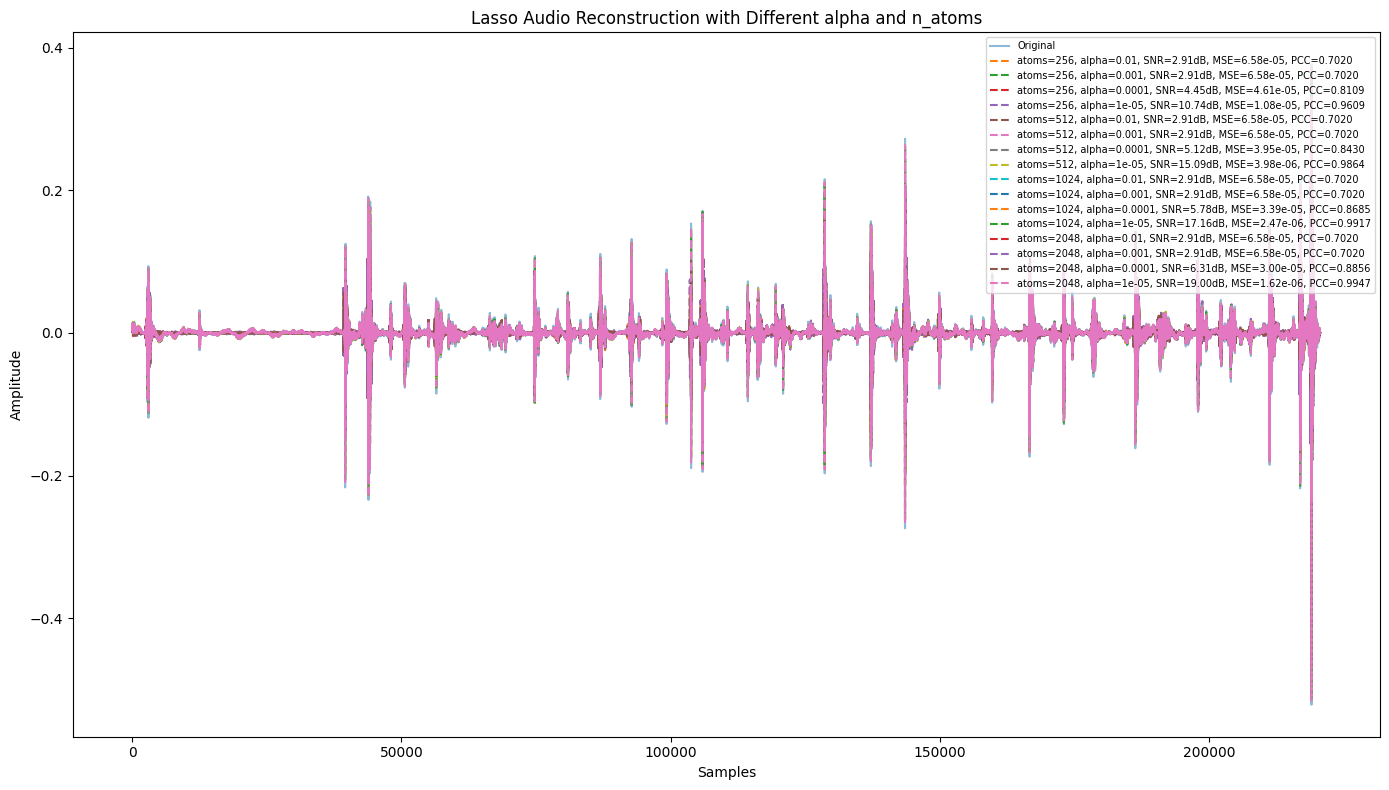

In [ ]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from scipy.signal import stft, istft
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import soundfile as sf

# ========== Step 1: Load Audio ==========
audio_path = './1-137-A-32.wav'
y, sr = librosa.load(audio_path, sr=None)

# ========== Step 2: STFT ==========
f, t, Zxx = stft(y, fs=sr, nperseg=512)
Zxx_real = np.real(Zxx)

# ========== Step 3: Evaluation Function ==========
def compute_metrics(original, reconstructed):
    min_len = min(len(original), len(reconstructed))
    original = original[:min_len]
    reconstructed = reconstructed[:min_len]
    noise = original - reconstructed
    snr = 10 * np.log10(np.sum(original**2) / (np.sum(noise**2) + 1e-12))
    mse = mean_squared_error(original, reconstructed)
    pcc, _ = pearsonr(original, reconstructed)
    return snr, mse, pcc

# ========== Step 4: Test Different Parameters ==========
n_atoms_list = [256, 512, 1024, 2048]
alpha_list = [0.01, 0.001, 0.0001, 0.00001]
results = {}

for n_atoms in n_atoms_list:
    for alpha in alpha_list:
        # print(f"Processing: n_atoms={n_atoms}, alpha={alpha}")
        dictionary = np.random.randn(Zxx_real.shape[0], n_atoms)
        lasso = Lasso(alpha=alpha, max_iter=1000)
        sparse_coeffs = np.zeros((n_atoms, Zxx_real.shape[1]))

        for i in range(Zxx_real.shape[1]):
            lasso.fit(dictionary, Zxx_real[:, i])
            sparse_coeffs[:, i] = lasso.coef_

        Zxx_reconstructed = dictionary @ sparse_coeffs
        _, y_reconstructed = istft(Zxx_reconstructed + 1j * np.imag(Zxx), fs=sr, nperseg=512)

        snr, mse, pcc = compute_metrics(y, y_reconstructed)

        results[(n_atoms, alpha)] = {
            'signal': y_reconstructed,
            'snr': snr,
            'mse': mse,
            'pcc': pcc
        }

        # Save audio
        filename = f'reconstructed_atoms{n_atoms}_alpha{alpha}.wav'
        sf.write(filename, y_reconstructed, sr)

# ========== Step 5: Plotting Results ==========
plt.figure(figsize=(8, 6))
plt.plot(y, label="Original", alpha=0.5)

for (n_atoms, alpha), res in results.items():
    y_recon = res['signal']
    snr = res['snr']
    mse = res['mse']
    pcc = res['pcc']
    plt.plot(
        y_recon,
        '--',
        label=f"atoms={n_atoms}, alpha={alpha}, SNR={snr:.2f}dB, MSE={mse:.2e}, PCC={pcc:.4f}"
    )

plt.title("Lasso Audio Reconstruction with Different alpha and n_atoms")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend(fontsize=7, loc='upper right')
plt.tight_layout()
plt.show()
